#Neural Style Transfer with Tensorflow 2.0


Neural Style transfer is a process by which a semi trained convolutional neural network is used to transfer the stylistic details of one image and render another image with the learned styles. The process involves two images - a content image on which the style is imposed and a style image from which the style is copied. The idea of the neural style transfer algorithm was introduced in the paper [A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf), by Gatys et al.

We start by importing all the necessary libraries. We use VGG19 
model's pretrained weights to help simplify the process, and avoid training a whole image classifier. We'll use `time` to initialize our seed randomly and `matplotlib.pyplot` for our images.

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import time
import PIL.Image

np.random.seed(int(time.time()))
%matplotlib inline

In [0]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

We will now resize and process the image for TensorFlow's purposes to make it uniformly sized. It would therefore help to provide images which are already clean. Let's also plot the images for a quick look before running them on the algorithm. The files here are stored locally on the Google Drive, but the path can be changed to the directory where your file is.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


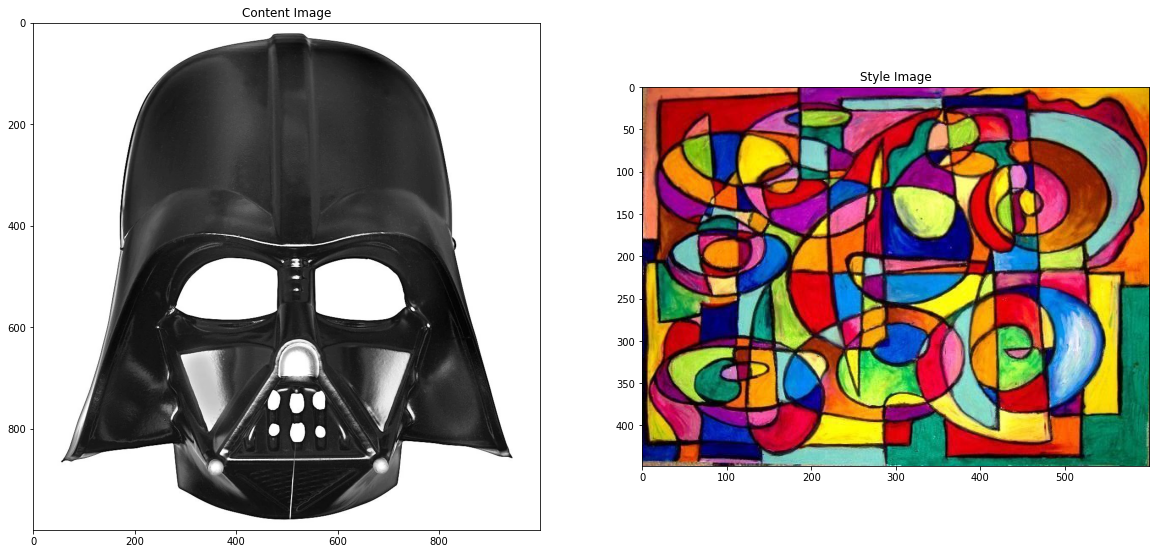

In [0]:
content_path = '/content/drive/My Drive/Neural Style Transfer/Images/vader.jpg'
style_path = '/content/drive/My Drive/Neural Style Transfer/Images/styles/picasso.jpg'

content = plt.imread(content_path)
style = plt.imread(style_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()

In [0]:
def load_image(image):
  dim = 512
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [dim, dim])
  img = img[tf.newaxis, :]
  return img

In [0]:
content = load_image(content_path)
style = load_image(style_path)

Here, we use the [VGG19 model](https://arxiv.org/pdf/1409.1556.pdf). It was a winner in the 2014 ImageNet challenge, and we take the pretrained weights to reuse them again. We extract features from the original and the style image with this. At the second layer from the fourth convolution block, we extract the original image features. Here we stop and calculate the content loss to find out how much content from the original image we lose. Similarly for the style loss, the paper advises the extraction of representations from five layers - the first layer from the first five convolutional blocks. So we pull out only the layers we need from the VGG architechture, and run forward passes on it to get our features. From the multiple layer for the style image, we make a "gram matrix". This would help us determine how similar the features are within a single layer, and also help in learning a arbitrary non localized features. For the gram matrix, we simply take a convoluted image, of say $m \times n \times f$, where $f$ is the number of feature maps, then we simple reshape it into a matrix of shape $f \times mn$ and multiply it with its transpose. This gives us a matrix of the form $f \times f$ which will be our gram matrix. Finally, we modify and build a custom model to do our style transfer.

In [0]:
content_layers = ['block4_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg_model.trainable = False

In [0]:
def custom_vgg_model(layer_names, model):
  outputs = [model.get_layer(name).output for name in layer_names]
  model = Model([vgg_model.input], outputs)
  return model

In [0]:
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze(temp)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = tf.matmul(temp, temp, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  return gram

In [0]:
class Style_Model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(Style_Model, self).__init__()
    self.vgg =  custom_vgg_model(style_layers + content_layers, vgg_model)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [0]:
extractor = Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

The last piece of the jigsaw puzzle is actually calculating the loss for the model. The content loss can be simply calculated as follows, considering $T$ as the target image and $C$ as the original content image.
$$L_{content} = \frac{1}{2} \sum (T - C) ^2$$
The style loss is calculated as follows, with $T$ again being the target image and $S$ being the style image. As we extract from multiple layers, we iterate through $i$ while summing. $a$ is a small constant and $w_i$ is the tiny weights to give importance to each layer considered.
$$L_{style} = a \sum_i w_i (T_i - S_i)^2$$
The total loss is hence put together as follows, with $\alpha$, the content weight, and $\beta$, the overall style weight, as hyperparameters.
$$L = \alpha L_{content} + \beta L_{style}$$
The values of the variables in the code block below can be modified to experiment with the various outputs.

In [0]:
style_weight=1000           # beta
content_weight=10           # alpha

# w_i
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

In [0]:
def total_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss
    return loss

To deal with the various high frequency artifacts in the image, we can include a regularization term which will decrease their influence, and this is called the variational loss. 

In [0]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

In [0]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [0]:
total_variation_weight=30

Finally, we put it all together and train the model with the Adam optimizer in tensorflow with a learning rate of 0.01. We alsso decorate the image train step with the [`tf.function`](https://www.tensorflow.org/guide/function) decorator, which will massively speed up the running time for our algorithm. We assign the output image to a TensorFlow variable. We then run the model for some epochs, and make it show the image at the end of every epoch. We let each epoch run for a variable number of steps, and these are hyperparameters which can be modified.

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02)

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = total_loss(outputs) + total_variation_weight*tf.image.total_variation(image)
  
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [0]:
target_image = tf.Variable(content)

Step 1 took 9.246222972869873 sec(s)
Step 2 took 9.095320701599121 sec(s)
Step 3 took 9.022337913513184 sec(s)
Step 4 took 9.080456018447876 sec(s)
Step 5 took 9.067537784576416 sec(s)
Step 6 took 9.044036865234375 sec(s)
Step 7 took 9.057277917861938 sec(s)
Step 8 took 9.067992210388184 sec(s)
Step 9 took 9.054410219192505 sec(s)
Step 10 took 9.037545204162598 sec(s)
Step 11 took 9.10897970199585 sec(s)
Step 12 took 9.055266618728638 sec(s)
Step 13 took 9.052414417266846 sec(s)
Step 14 took 9.036844253540039 sec(s)
Step 15 took 9.07908296585083 sec(s)
Step 16 took 9.089244365692139 sec(s)
Step 17 took 9.046126127243042 sec(s)
Step 18 took 9.141274690628052 sec(s)
Step 19 took 9.109052658081055 sec(s)
Step 20 took 9.068252801895142 sec(s)
Step 21 took 9.074984073638916 sec(s)
Step 22 took 9.065715551376343 sec(s)
Step 23 took 9.016105651855469 sec(s)
Step 24 took 9.077269315719604 sec(s)
Step 25 took 9.127685785293579 sec(s)
Step 26 took 9.099642276763916 sec(s)
Step 27 took 9.04155921

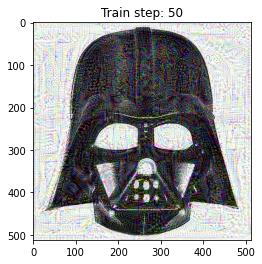

Epoch 1 took 453.68427634239197 sec(s)
Step 51 took 9.089352130889893 sec(s)
Step 52 took 9.060340642929077 sec(s)
Step 53 took 9.053969144821167 sec(s)
Step 54 took 9.017072677612305 sec(s)
Step 55 took 9.023948907852173 sec(s)
Step 56 took 9.036162614822388 sec(s)
Step 57 took 9.042766332626343 sec(s)
Step 58 took 11.140102624893188 sec(s)
Step 59 took 9.69099736213684 sec(s)
Step 60 took 9.04915976524353 sec(s)
Step 61 took 9.042467832565308 sec(s)
Step 62 took 9.03835153579712 sec(s)
Step 63 took 9.015116691589355 sec(s)
Step 64 took 9.041778326034546 sec(s)
Step 65 took 9.070647239685059 sec(s)
Step 66 took 9.050501585006714 sec(s)
Step 67 took 9.060174226760864 sec(s)
Step 68 took 9.102635622024536 sec(s)
Step 69 took 9.045648336410522 sec(s)
Step 70 took 9.101394176483154 sec(s)
Step 71 took 9.117996454238892 sec(s)
Step 72 took 9.088456869125366 sec(s)
Step 73 took 9.056528329849243 sec(s)
Step 74 took 9.021358728408813 sec(s)
Step 75 took 9.090751647949219 sec(s)
Step 76 took 

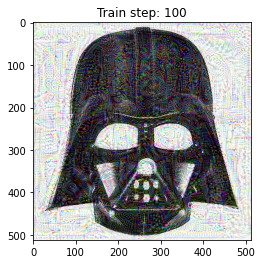

Epoch 2 took 456.0344989299774 sec(s)
Step 101 took 9.14542531967163 sec(s)
Step 102 took 9.072240352630615 sec(s)
Step 103 took 9.079957723617554 sec(s)
Step 104 took 9.06834101676941 sec(s)
Step 105 took 9.092541456222534 sec(s)
Step 106 took 9.065999746322632 sec(s)
Step 107 took 9.062235832214355 sec(s)
Step 108 took 9.077678918838501 sec(s)
Step 109 took 9.087700605392456 sec(s)
Step 110 took 8.999469757080078 sec(s)
Step 111 took 9.09474515914917 sec(s)
Step 112 took 9.073533296585083 sec(s)
Step 113 took 9.068183183670044 sec(s)
Step 114 took 9.073612689971924 sec(s)
Step 115 took 9.081092834472656 sec(s)
Step 116 took 9.071830034255981 sec(s)
Step 117 took 9.081670761108398 sec(s)
Step 118 took 9.098802328109741 sec(s)
Step 119 took 9.099036455154419 sec(s)
Step 120 took 9.052740812301636 sec(s)
Step 121 took 9.091722249984741 sec(s)
Step 122 took 9.047112464904785 sec(s)
Step 123 took 9.10802936553955 sec(s)
Step 124 took 9.09708023071289 sec(s)
Step 125 took 11.98272800445556

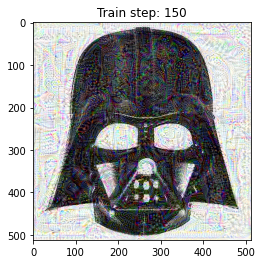

Epoch 3 took 458.0035033226013 sec(s)
Step 151 took 9.137259721755981 sec(s)
Step 152 took 9.152182340621948 sec(s)
Step 153 took 9.092933177947998 sec(s)
Step 154 took 9.127071619033813 sec(s)
Step 155 took 9.065006732940674 sec(s)
Step 156 took 9.108346700668335 sec(s)
Step 157 took 9.110137224197388 sec(s)
Step 158 took 9.12381386756897 sec(s)
Step 159 took 9.069002628326416 sec(s)
Step 160 took 9.075329065322876 sec(s)
Step 161 took 9.058377027511597 sec(s)
Step 162 took 9.11316704750061 sec(s)
Step 163 took 9.047871589660645 sec(s)
Step 164 took 9.10672903060913 sec(s)
Step 165 took 9.037486553192139 sec(s)
Step 166 took 9.092532873153687 sec(s)
Step 167 took 9.085247278213501 sec(s)
Step 168 took 9.232072353363037 sec(s)
Step 169 took 9.215694665908813 sec(s)
Step 170 took 9.06332802772522 sec(s)
Step 171 took 9.144198894500732 sec(s)
Step 172 took 9.094340801239014 sec(s)
Step 173 took 9.081283807754517 sec(s)
Step 174 took 9.077924489974976 sec(s)
Step 175 took 9.08621668815612

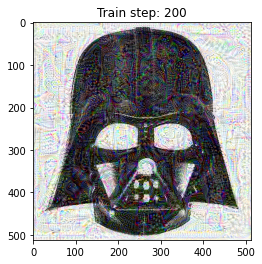

Epoch 4 took 457.8531653881073 sec(s)
Step 201 took 9.13294768333435 sec(s)
Step 202 took 9.033851385116577 sec(s)
Step 203 took 9.189068078994751 sec(s)
Step 204 took 9.226973295211792 sec(s)
Step 205 took 9.15875244140625 sec(s)
Step 206 took 9.179264545440674 sec(s)
Step 207 took 9.090793371200562 sec(s)
Step 208 took 9.072300434112549 sec(s)
Step 209 took 9.129018545150757 sec(s)
Step 210 took 9.124140501022339 sec(s)
Step 211 took 9.067052364349365 sec(s)
Step 212 took 9.113652467727661 sec(s)
Step 213 took 9.081011533737183 sec(s)
Step 214 took 9.047318458557129 sec(s)
Step 215 took 9.081733465194702 sec(s)
Step 216 took 9.096635818481445 sec(s)
Step 217 took 9.035626411437988 sec(s)
Step 218 took 9.093098878860474 sec(s)
Step 219 took 9.081333637237549 sec(s)
Step 220 took 9.096249103546143 sec(s)
Step 221 took 9.114897727966309 sec(s)
Step 222 took 9.10432505607605 sec(s)
Step 223 took 9.113428592681885 sec(s)
Step 224 took 9.055447578430176 sec(s)
Step 225 took 9.0869233608245

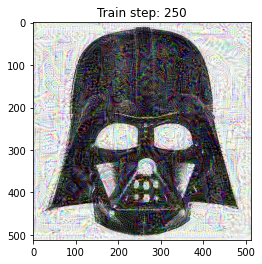

Epoch 5 took 455.7902867794037 sec(s)
Step 251 took 9.194787979125977 sec(s)
Step 252 took 9.091918468475342 sec(s)
Step 253 took 9.133914947509766 sec(s)
Step 254 took 9.08524751663208 sec(s)
Step 255 took 9.115067481994629 sec(s)
Step 256 took 9.173866748809814 sec(s)
Step 257 took 9.064267873764038 sec(s)
Step 258 took 10.06372356414795 sec(s)
Step 259 took 10.924543857574463 sec(s)
Step 260 took 9.1326744556427 sec(s)
Step 261 took 9.084199905395508 sec(s)
Step 262 took 9.1506986618042 sec(s)
Step 263 took 9.066798686981201 sec(s)
Step 264 took 9.124611854553223 sec(s)
Step 265 took 9.138483762741089 sec(s)
Step 266 took 9.131227254867554 sec(s)
Step 267 took 9.136093854904175 sec(s)
Step 268 took 9.159753322601318 sec(s)
Step 269 took 9.190941572189331 sec(s)
Step 270 took 9.11032247543335 sec(s)
Step 271 took 9.085941791534424 sec(s)
Step 272 took 9.157092809677124 sec(s)
Step 273 took 9.175059795379639 sec(s)
Step 274 took 9.13706636428833 sec(s)
Step 275 took 9.116169691085815 

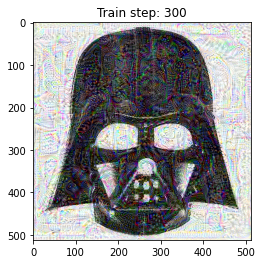

Epoch 6 took 463.2486846446991 sec(s)
Step 301 took 9.424468994140625 sec(s)
Step 302 took 9.417490243911743 sec(s)
Step 303 took 9.2763512134552 sec(s)
Step 304 took 9.330736637115479 sec(s)
Step 305 took 9.353028774261475 sec(s)
Step 306 took 9.396016120910645 sec(s)
Step 307 took 9.49390721321106 sec(s)
Step 308 took 9.4135582447052 sec(s)
Step 309 took 9.45169734954834 sec(s)
Step 310 took 9.356374263763428 sec(s)
Step 311 took 9.360995054244995 sec(s)
Step 312 took 9.353175640106201 sec(s)
Step 313 took 9.36440110206604 sec(s)
Step 314 took 9.311786890029907 sec(s)
Step 315 took 9.328428268432617 sec(s)
Step 316 took 9.293118000030518 sec(s)
Step 317 took 9.340136051177979 sec(s)
Step 318 took 9.3257417678833 sec(s)
Step 319 took 9.359485149383545 sec(s)
Step 320 took 9.307927131652832 sec(s)
Step 321 took 9.324528217315674 sec(s)
Step 322 took 9.301532506942749 sec(s)
Step 323 took 9.340945720672607 sec(s)
Step 324 took 13.226124286651611 sec(s)
Step 325 took 9.449653387069702 se

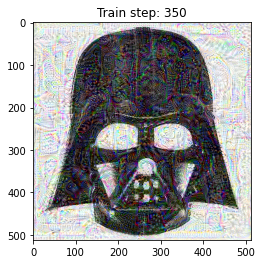

Epoch 7 took 471.81246304512024 sec(s)
Step 351 took 9.392565488815308 sec(s)
Step 352 took 9.296388149261475 sec(s)
Step 353 took 9.241636276245117 sec(s)
Step 354 took 9.249107360839844 sec(s)
Step 355 took 9.246685981750488 sec(s)
Step 356 took 9.192492723464966 sec(s)
Step 357 took 9.173006296157837 sec(s)
Step 358 took 9.20363450050354 sec(s)
Step 359 took 9.319478750228882 sec(s)
Step 360 took 9.200386762619019 sec(s)
Step 361 took 9.266454219818115 sec(s)
Step 362 took 9.364773511886597 sec(s)
Step 363 took 9.291804075241089 sec(s)
Step 364 took 9.358706951141357 sec(s)
Step 365 took 9.32187533378601 sec(s)
Step 366 took 9.371427536010742 sec(s)
Step 367 took 9.340791463851929 sec(s)
Step 368 took 9.355464696884155 sec(s)
Step 369 took 9.307129383087158 sec(s)
Step 370 took 9.31492018699646 sec(s)
Step 371 took 9.3151113986969 sec(s)
Step 372 took 9.322293519973755 sec(s)
Step 373 took 9.37335991859436 sec(s)
Step 374 took 9.268379211425781 sec(s)
Step 375 took 9.347131252288818

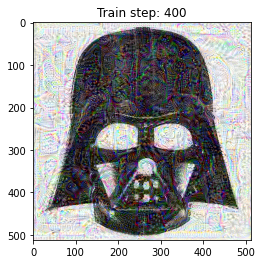

Epoch 8 took 465.6077904701233 sec(s)
Step 401 took 9.257698059082031 sec(s)
Step 402 took 9.132785320281982 sec(s)
Step 403 took 9.158924579620361 sec(s)
Step 404 took 9.181972742080688 sec(s)
Step 405 took 9.188567638397217 sec(s)
Step 406 took 9.17239499092102 sec(s)
Step 407 took 9.264832973480225 sec(s)
Step 408 took 9.14373779296875 sec(s)
Step 409 took 9.18281865119934 sec(s)
Step 410 took 9.143996953964233 sec(s)
Step 411 took 9.139638185501099 sec(s)
Step 412 took 9.17454481124878 sec(s)
Step 413 took 9.225372314453125 sec(s)
Step 414 took 9.174131870269775 sec(s)
Step 415 took 9.209850311279297 sec(s)
Step 416 took 9.168157815933228 sec(s)
Step 417 took 9.214669704437256 sec(s)
Step 418 took 9.137724161148071 sec(s)
Step 419 took 9.161219120025635 sec(s)
Step 420 took 9.150318384170532 sec(s)
Step 421 took 9.216325521469116 sec(s)
Step 422 took 9.19455885887146 sec(s)
Step 423 took 9.160215139389038 sec(s)
Step 424 took 9.245290279388428 sec(s)
Step 425 took 9.183091402053833

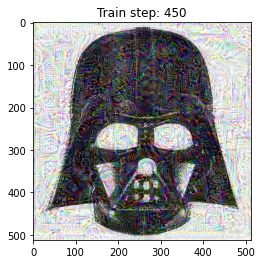

Epoch 9 took 459.60646200180054 sec(s)
Step 451 took 9.203538179397583 sec(s)
Step 452 took 9.160767316818237 sec(s)
Step 453 took 9.159559965133667 sec(s)
Step 454 took 9.150759935379028 sec(s)
Step 455 took 11.879237174987793 sec(s)
Step 456 took 9.114587783813477 sec(s)
Step 457 took 9.138023138046265 sec(s)
Step 458 took 9.0431067943573 sec(s)
Step 459 took 9.184648752212524 sec(s)


In [0]:
epochs = 20
steps_per_epoch = 50

step = 0
outputs = []

for n in range(epochs):
  Tic = time.time()
  for m in range(steps_per_epoch):
    step += 1
    tic = time.time()
    train_step(target_image)
    toc = time.time()
    print("Step " + str(step) + " took " + str(toc-tic) + " sec(s)")
    
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()
  Toc = time.time()
  print("Epoch " + str(n+1) + " took " + str(Toc-Tic) + " sec(s)")
  
  # file_name = 'clocktower-oil' + str(n+1) + '.png'
  outputs.append(tensor_to_image(target_image))



In [0]:
for i in range(len(outputs)):
  file_name = 'picasso-vader' + str(n+1) + '.png'
  outputs[i].save(file_name)
  try:
    from google.colab import files
  except ImportError:
    pass
  else:
    files.download(file_name)
